In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import bambi as bmb
from bambi.plots import plot_cap

In [2]:
az.style.use("arviz-grayscale")
from cycler import cycler

default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc("axes", prop_cycle=default_cycler)
plt.rc("figure", dpi=300)
np.random.seed(123)

In [3]:
SIZE = 117
data = pd.DataFrame(
    {
        "y": np.random.normal(size=SIZE),
        "x": np.random.normal(size=SIZE),
        "z": np.random.normal(size=SIZE),
        "g": ["Group A", "Group B", "Group C"] * 39,
    }
)
data.head()

,y,x,z,g
0,-1.085631,-0.332475,0.322577,Group A
1,0.997345,1.959411,-0.434167,Group B
2,0.282978,-2.025046,1.032480,Group C
3,-1.506295,-0.275786,-0.194343,Group A
4,-0.578600,-0.552108,0.594070,Group B


In [4]:
a_model = bmb.Model("y ~ x", data)

In [5]:
no_intercept_model = bmb.Model("y ~ x", data)
no_intercept_model

       Formula: y ~ x
        Family: gaussian
          Link: mu = identity
  Observations: 117
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.02, sigma: 2.8414)
            x ~ Normal(mu: 0.0, sigma: 3.1104)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.1348)

In [6]:
model_2 = bmb.Model("y ~ x + z", data)
model_2

       Formula: y ~ x + z
        Family: gaussian
          Link: mu = identity
  Observations: 117
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.02, sigma: 2.8478)
            x ~ Normal(mu: 0.0, sigma: 3.1104)
            z ~ Normal(mu: 0.0, sigma: 2.9966)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.1348)

In [7]:
model_h = bmb.Model("y ~ x + z + (x|g)", data)
model_h

       Formula: y ~ x + z + (x|g)
        Family: gaussian
          Link: mu = identity
  Observations: 117
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.02, sigma: 2.8478)
            x ~ Normal(mu: 0.0, sigma: 3.1104)
            z ~ Normal(mu: 0.0, sigma: 2.9966)
        
        Group-level effects
            1|g ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.8478))
            x|g ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.1104))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.1348)

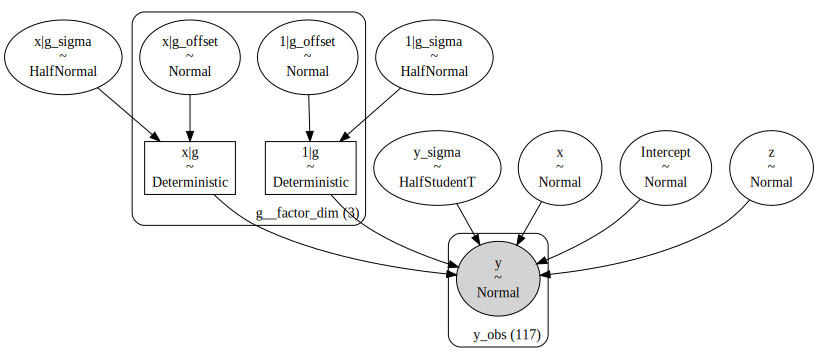

In [8]:
model_h.build()
model_h.graph(name="../fig/bambi_dag")

## Simple linear regression

In [9]:
bikes = pd.read_csv("data/bikes.csv")

In [10]:
model_t = bmb.Model("rented ~ temperature", bikes, family="negativebinomial")
idata_t = model_t.fit(random_seed=123)
model_t

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rented_alpha, Intercept, temperature]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


       Formula: rented ~ temperature
        Family: negativebinomial
          Link: mu = log
  Observations: 348
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 4.9184)
            temperature ~ Normal(mu: 0.0, sigma: 0.2741)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Sampling: [Intercept, rented_alpha, temperature]


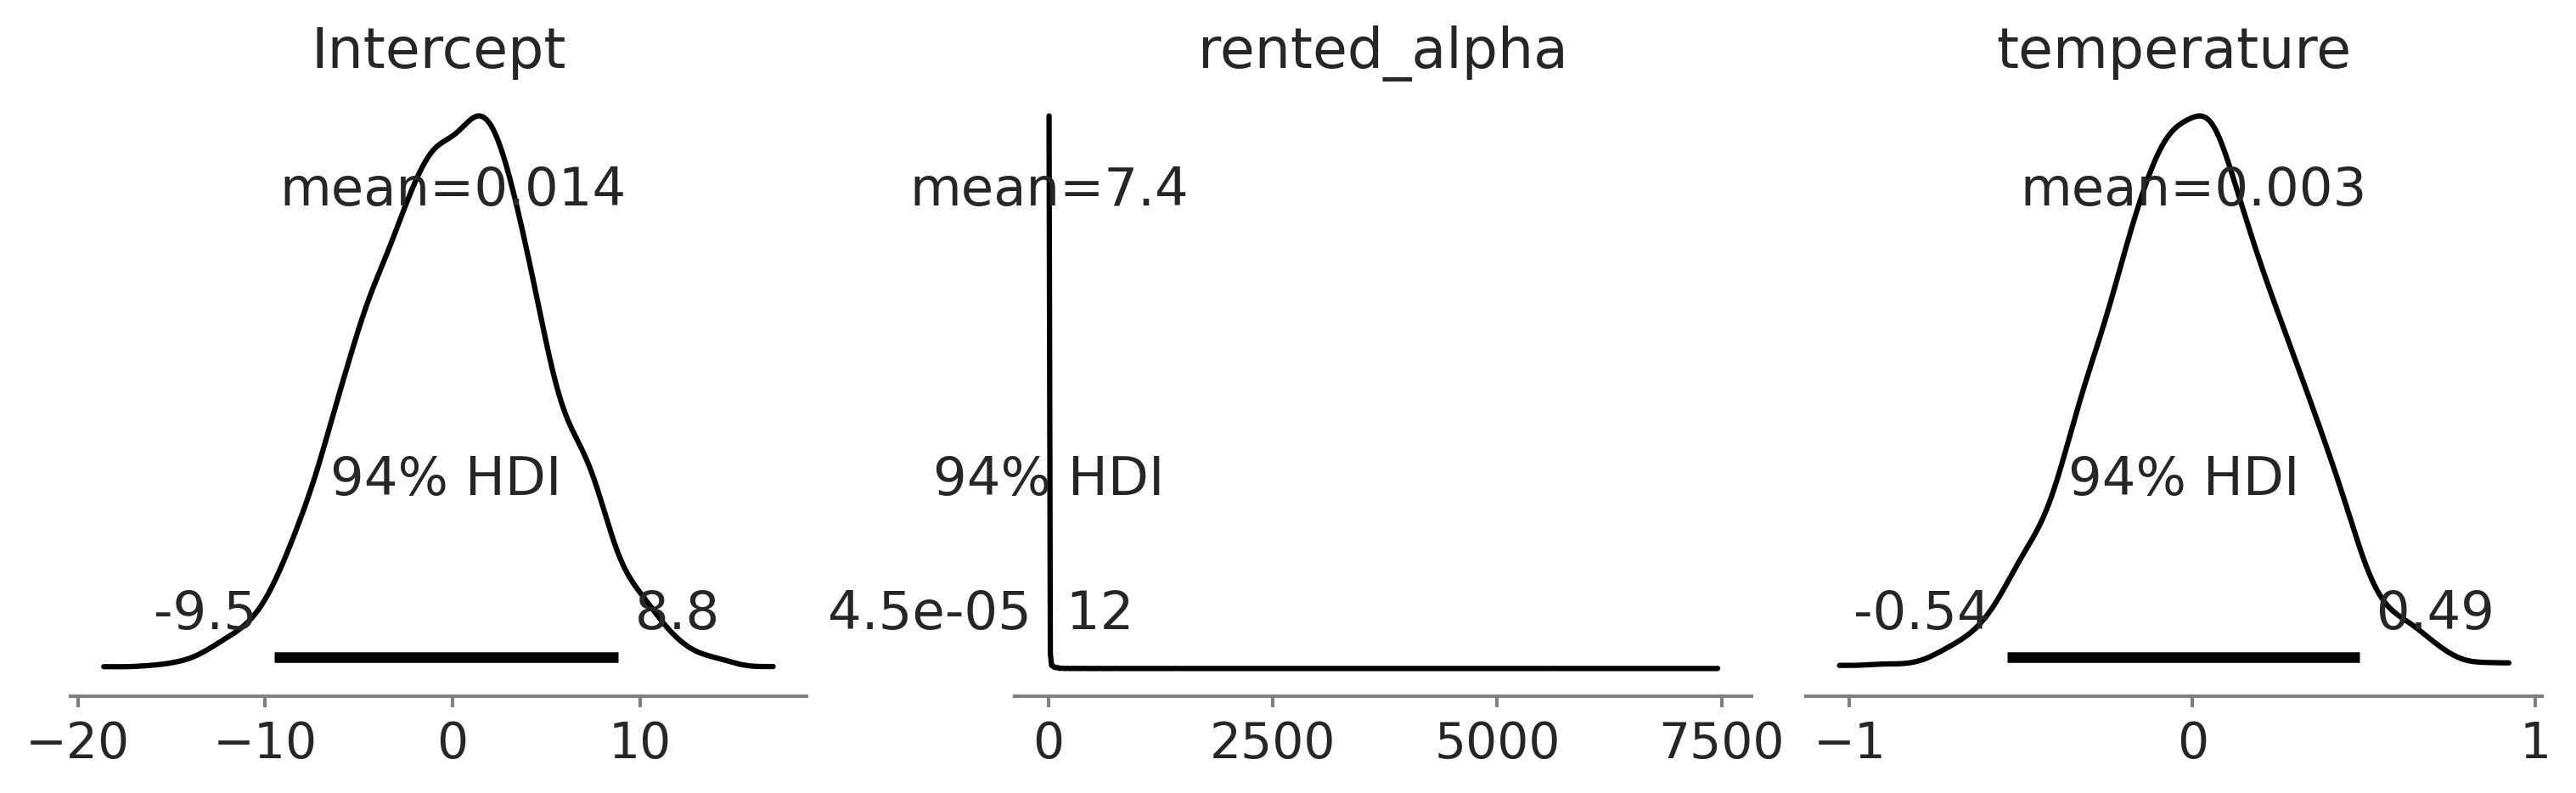

In [11]:
model_t.plot_priors(figsize=(10, 3));

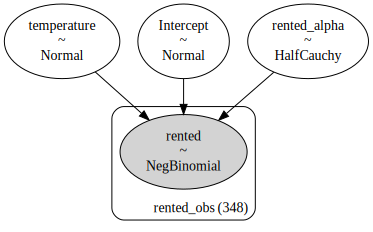

In [12]:
model_t.graph(name="../fig/bambi_linear_bikes_dag")

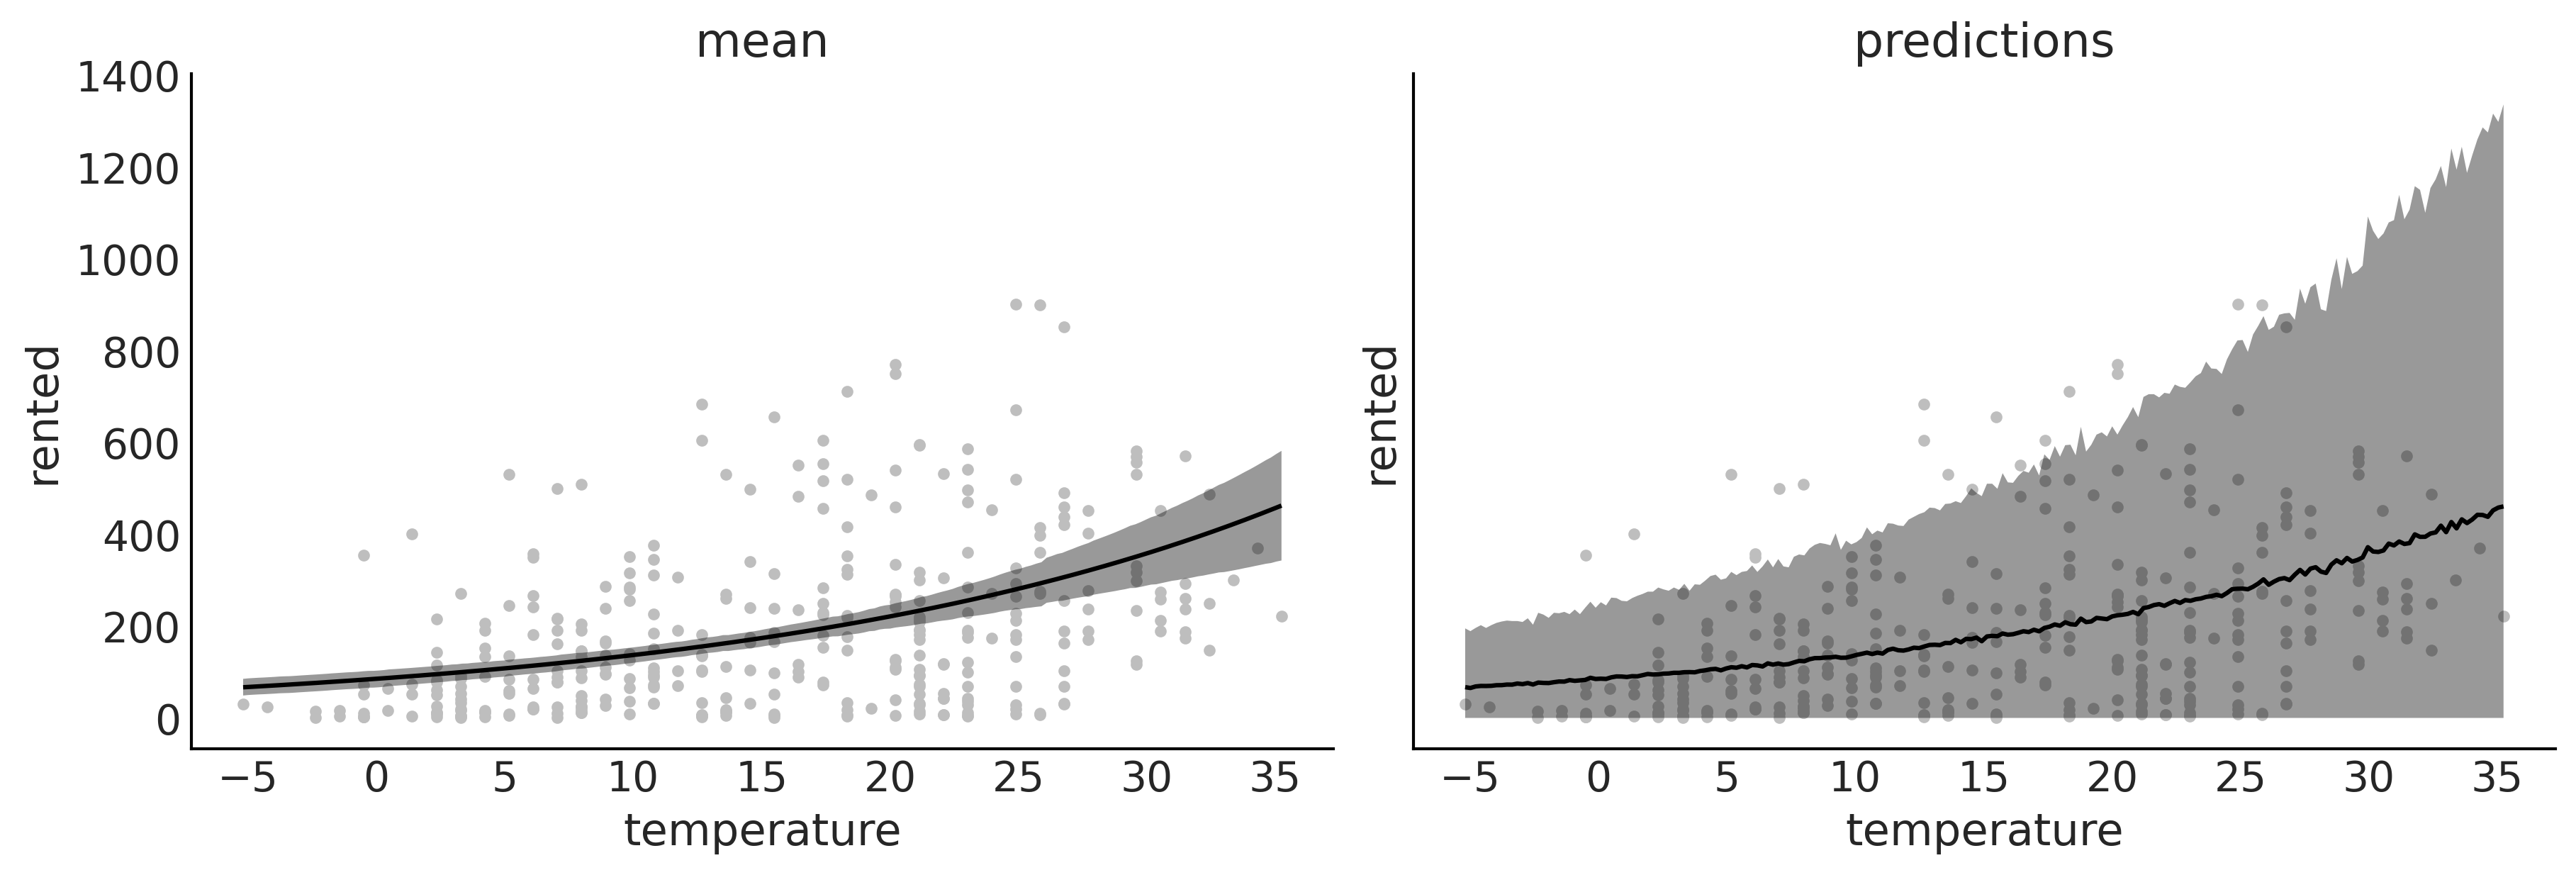

In [13]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4)) 
plot_cap(model_t, idata_t, "temperature", ax=axes[0])
plot_cap(model_t, idata_t, "temperature", pps=True, ax=axes[1])
axes[0].plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
axes[1].plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
axes[0].set_title("mean")
axes[1].set_title("predictions");
plt.savefig("../fig/bambi_linear_bikes_mean_pss.png")

In [14]:
model_th = bmb.Model("rented ~ temperature + humidity", bikes, family="negativebinomial")
idata_th = model_th.fit(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rented_alpha, Intercept, temperature, humidity]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


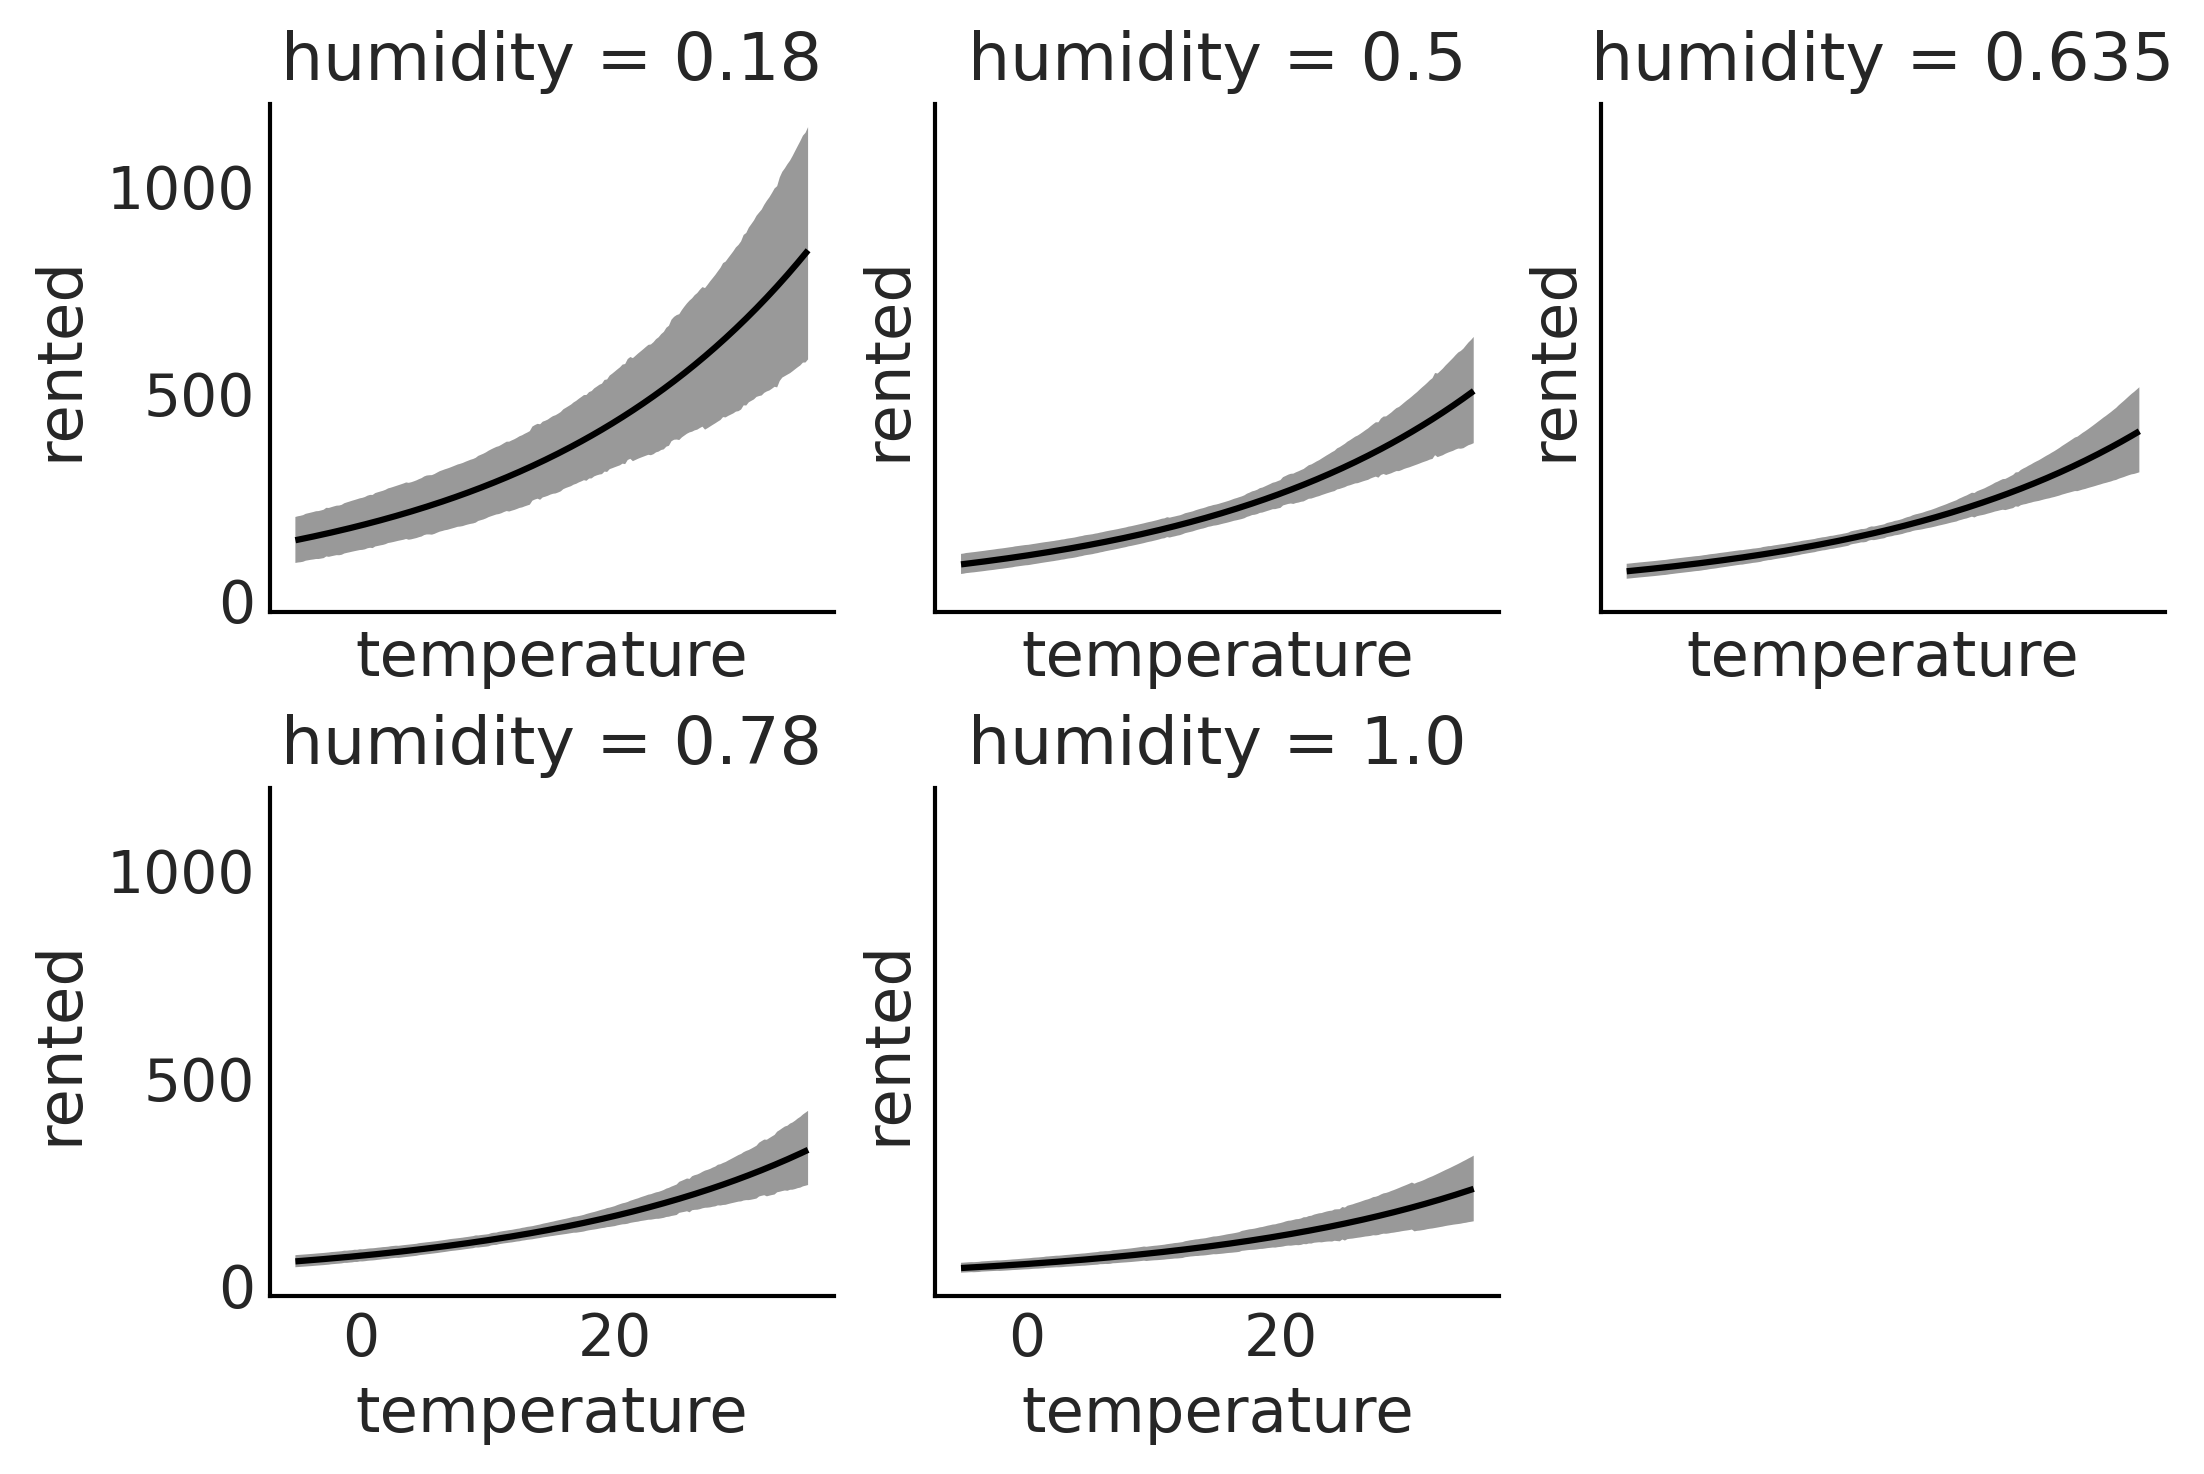

In [15]:
plot_cap(model_th, idata_th, {"horizontal": "temperature", "panel": "humidity"},
         fig_kwargs={"sharey":True, "sharex":True});
plt.savefig("../fig/bambi_linear_bikes_th_mean.png")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rented_alpha, Intercept, temperature, 1|weekday_sigma, 1|weekday_offset, temperature|weekday_sigma, temperature|weekday_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.


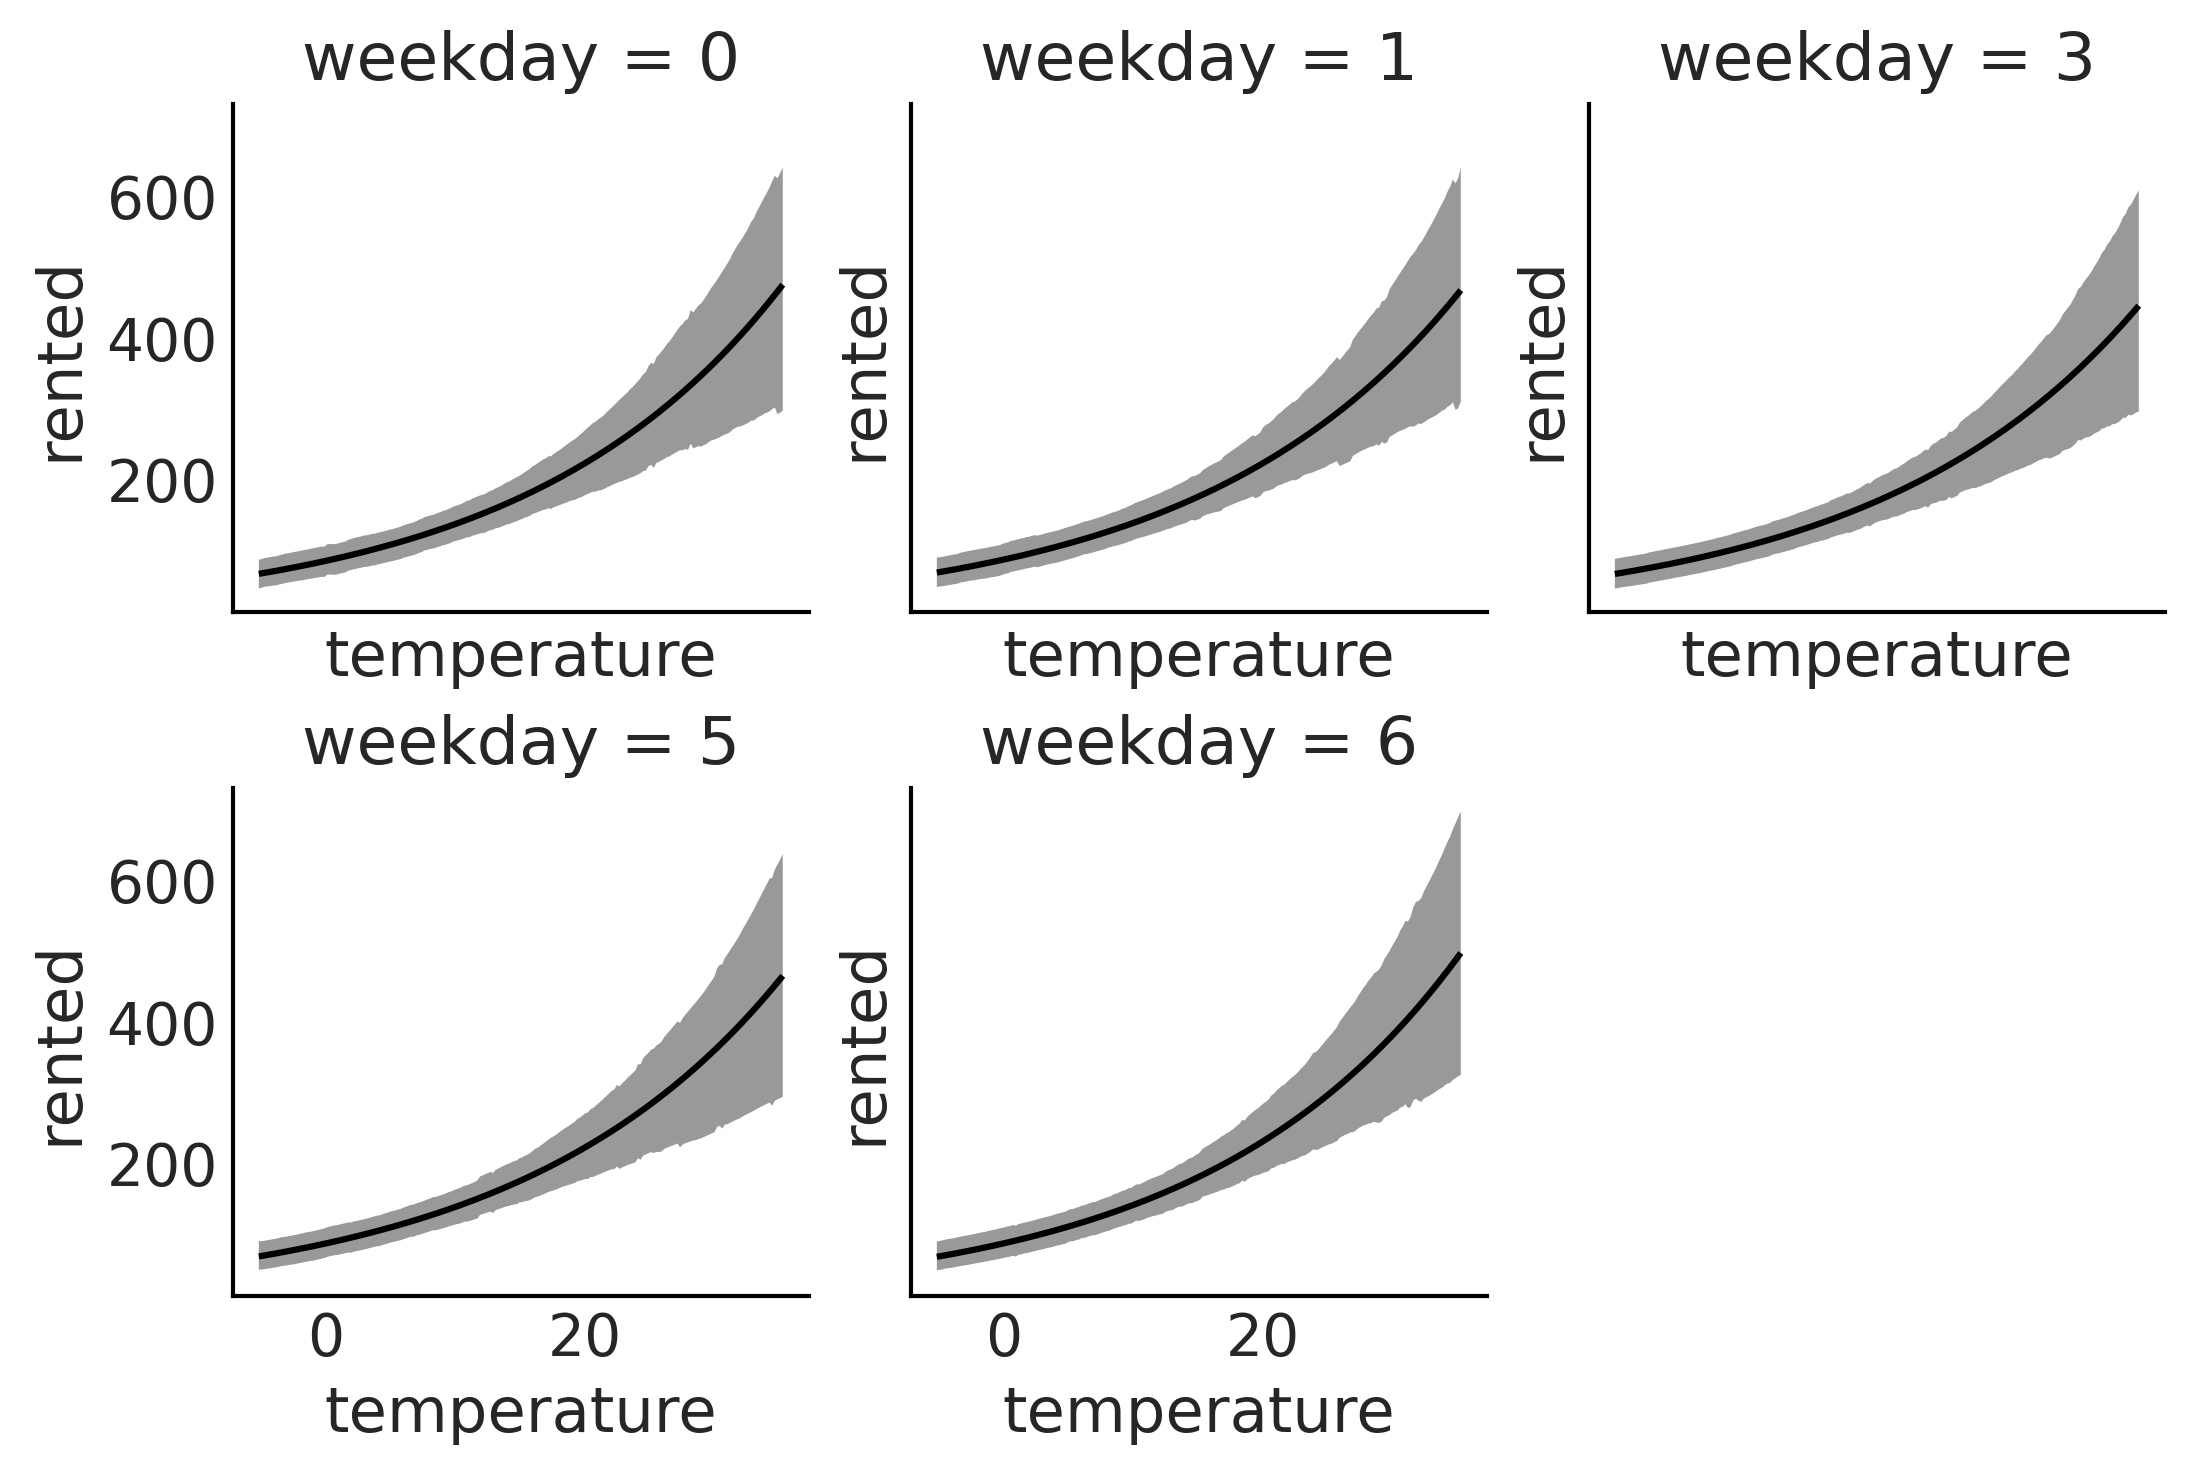

In [16]:
model_tg = bmb.Model("rented ~ temperature + (temperature | weekday)", bikes, family="negativebinomial")
idata_tg = model_tg.fit()
plot_cap(model_tg, idata_tg, {"horizontal": "temperature", "panel": "weekday"},
         fig_kwargs={"sharey":True, "sharex":True});

In [17]:
## Multinomial / Categorical models

## Polynomial and Splines

In [18]:
model_poly_1 = bmb.Model("rented ~ hour", bikes, family="negativebinomial")
idata_poly_1 = model_poly_1.fit(random_seed=123)
model_poly_4 = bmb.Model("rented ~ poly(hour, degree=4)", bikes, family="negativebinomial")
idata_poly_4 = model_poly_4.fit(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rented_alpha, Intercept, hour]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rented_alpha, Intercept, poly(hour, degree=4)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


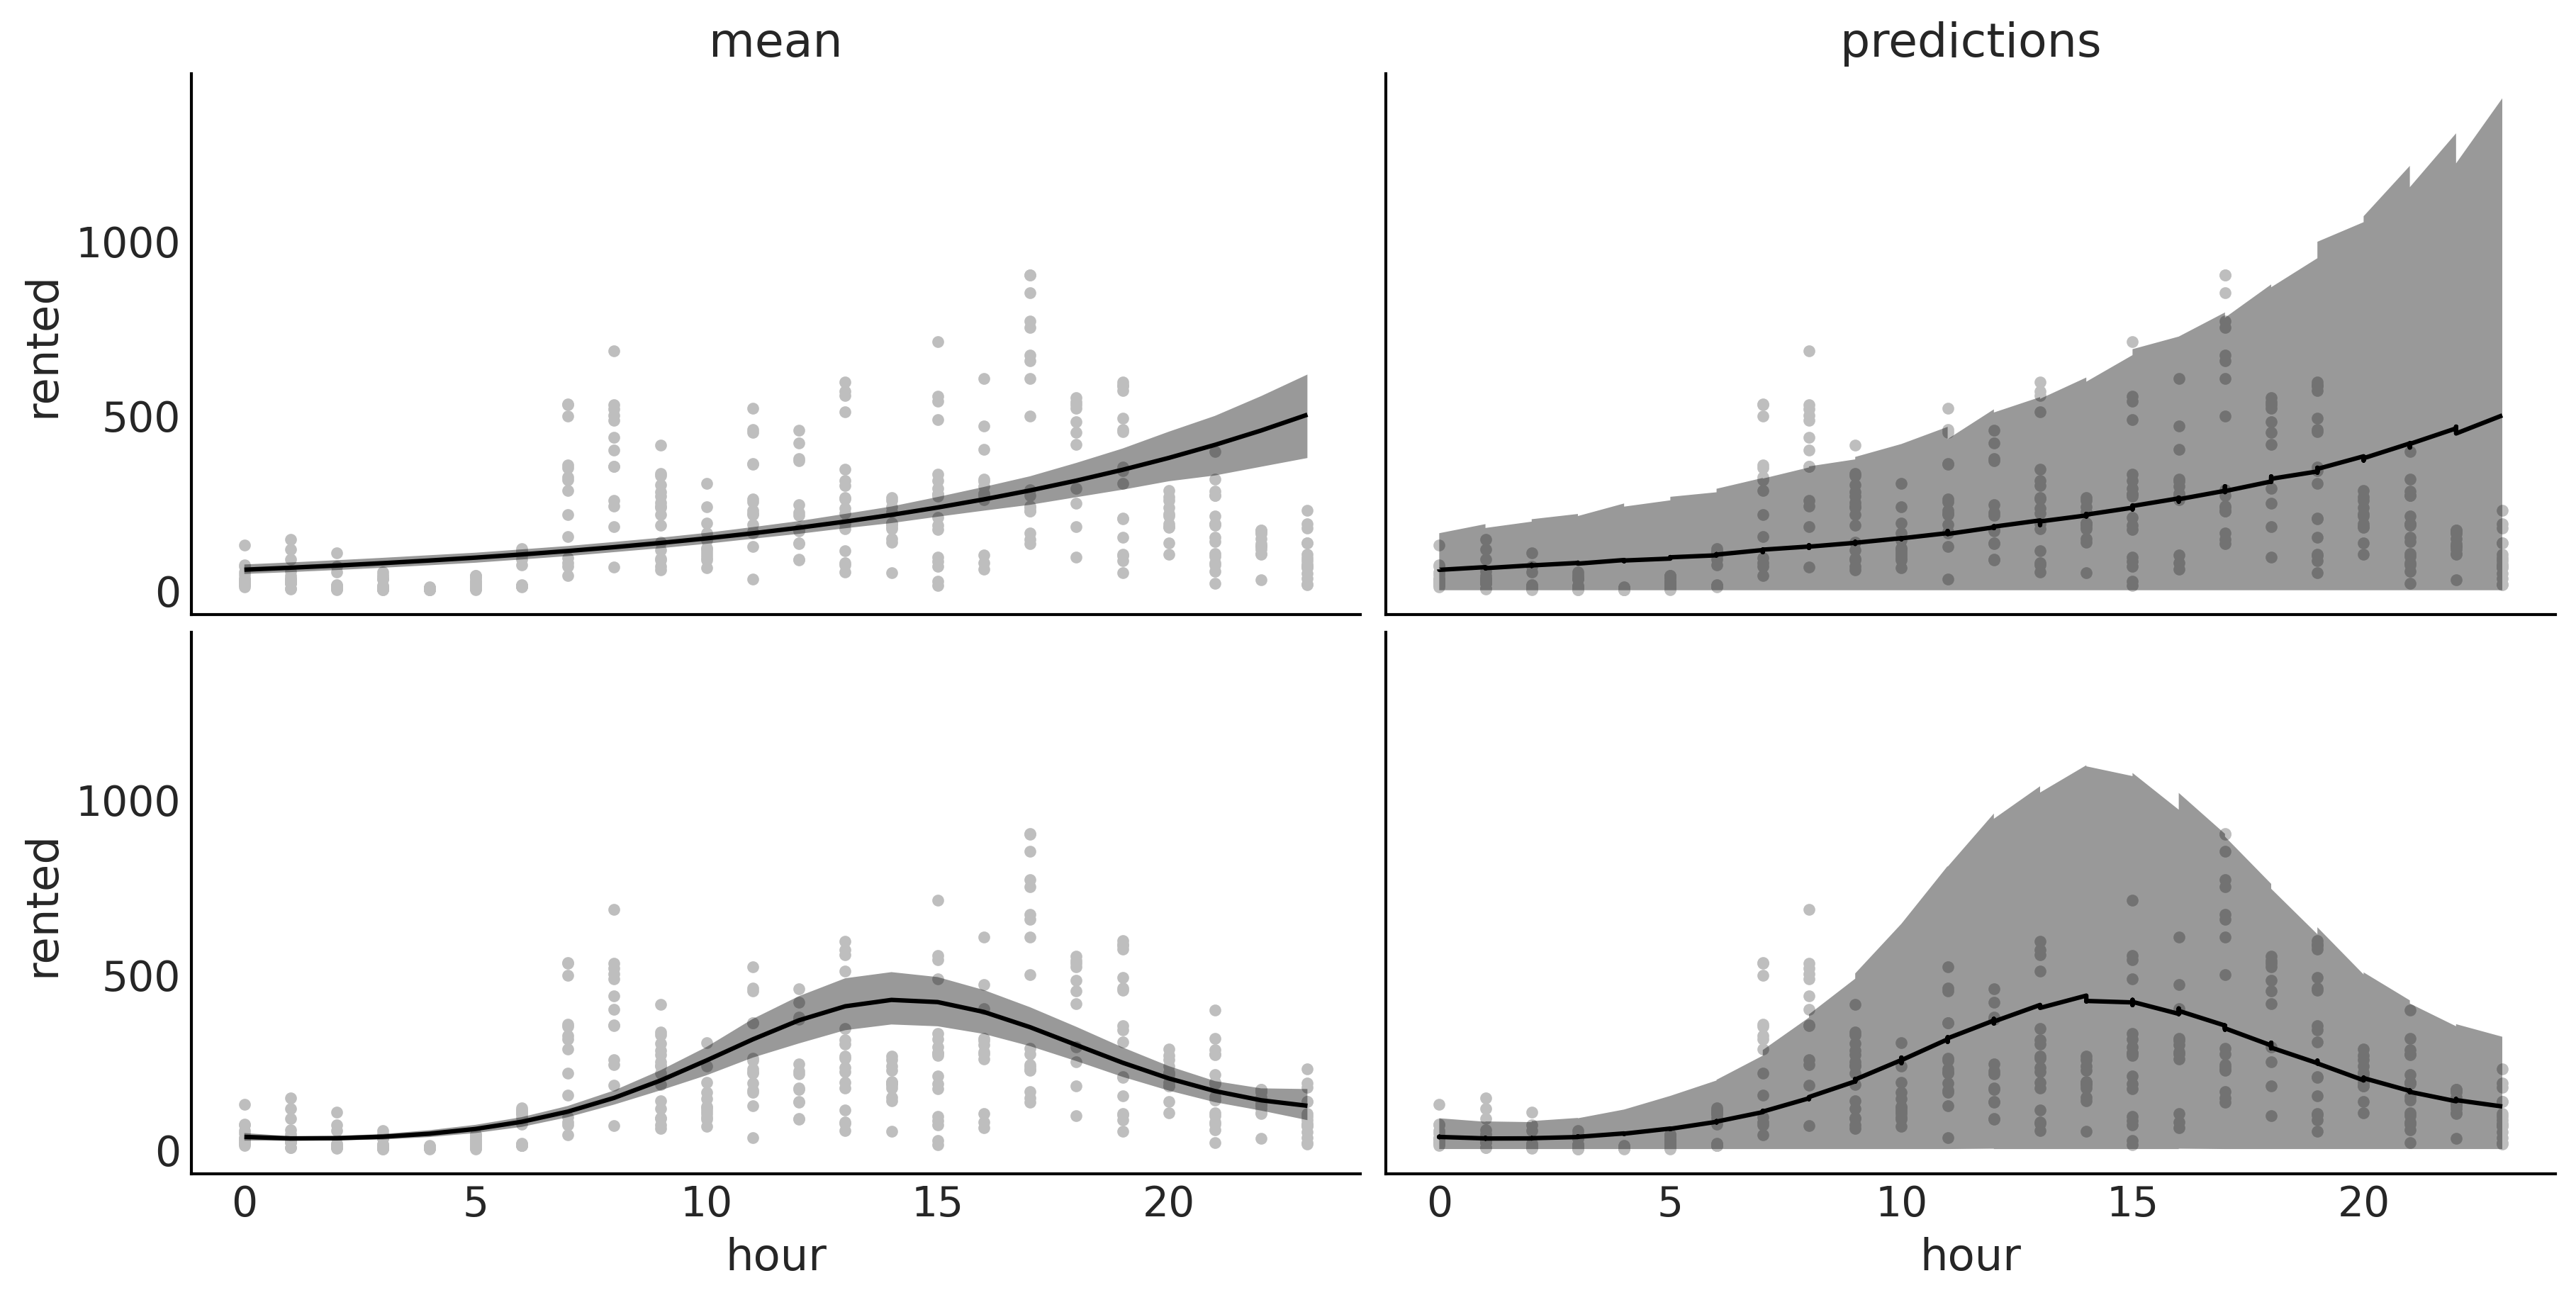

In [19]:
_, axes = plt.subplots(2, 2, sharey=True, sharex="col", figsize=(12, 6)) 
plot_cap(model_poly_1, idata_poly_1, "hour", ax=axes[0, 0])
plot_cap(model_poly_1, idata_poly_1, "hour", pps=True, ax=axes[0, 1])
plot_cap(model_poly_4, idata_poly_4, "hour", ax=axes[1, 0])
plot_cap(model_poly_4, idata_poly_4, "hour", pps=True, ax=axes[1, 1])

for ax in axes.ravel():
    ax.plot(bikes.hour, bikes.rented, "C2.", zorder=-3)
axes[0, 0].set_title("mean")
axes[0, 1].set_title("predictions")
axes[0, 0].set_xlabel("")
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("")
axes[1, 1].set_ylabel("")

plt.savefig("../fig/bambi_poly_bikes_mean_pss.png")

In [20]:
num_knots = 6
knots = np.linspace(0, 23, num_knots+2)[1:-1]
model_spline = bmb.Model("rented ~ bs(hour, degree=3, knots=knots)", bikes, family="negativebinomial")
idata_spline = model_spline.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rented_alpha, Intercept, bs(hour, degree=3, knots=knots)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


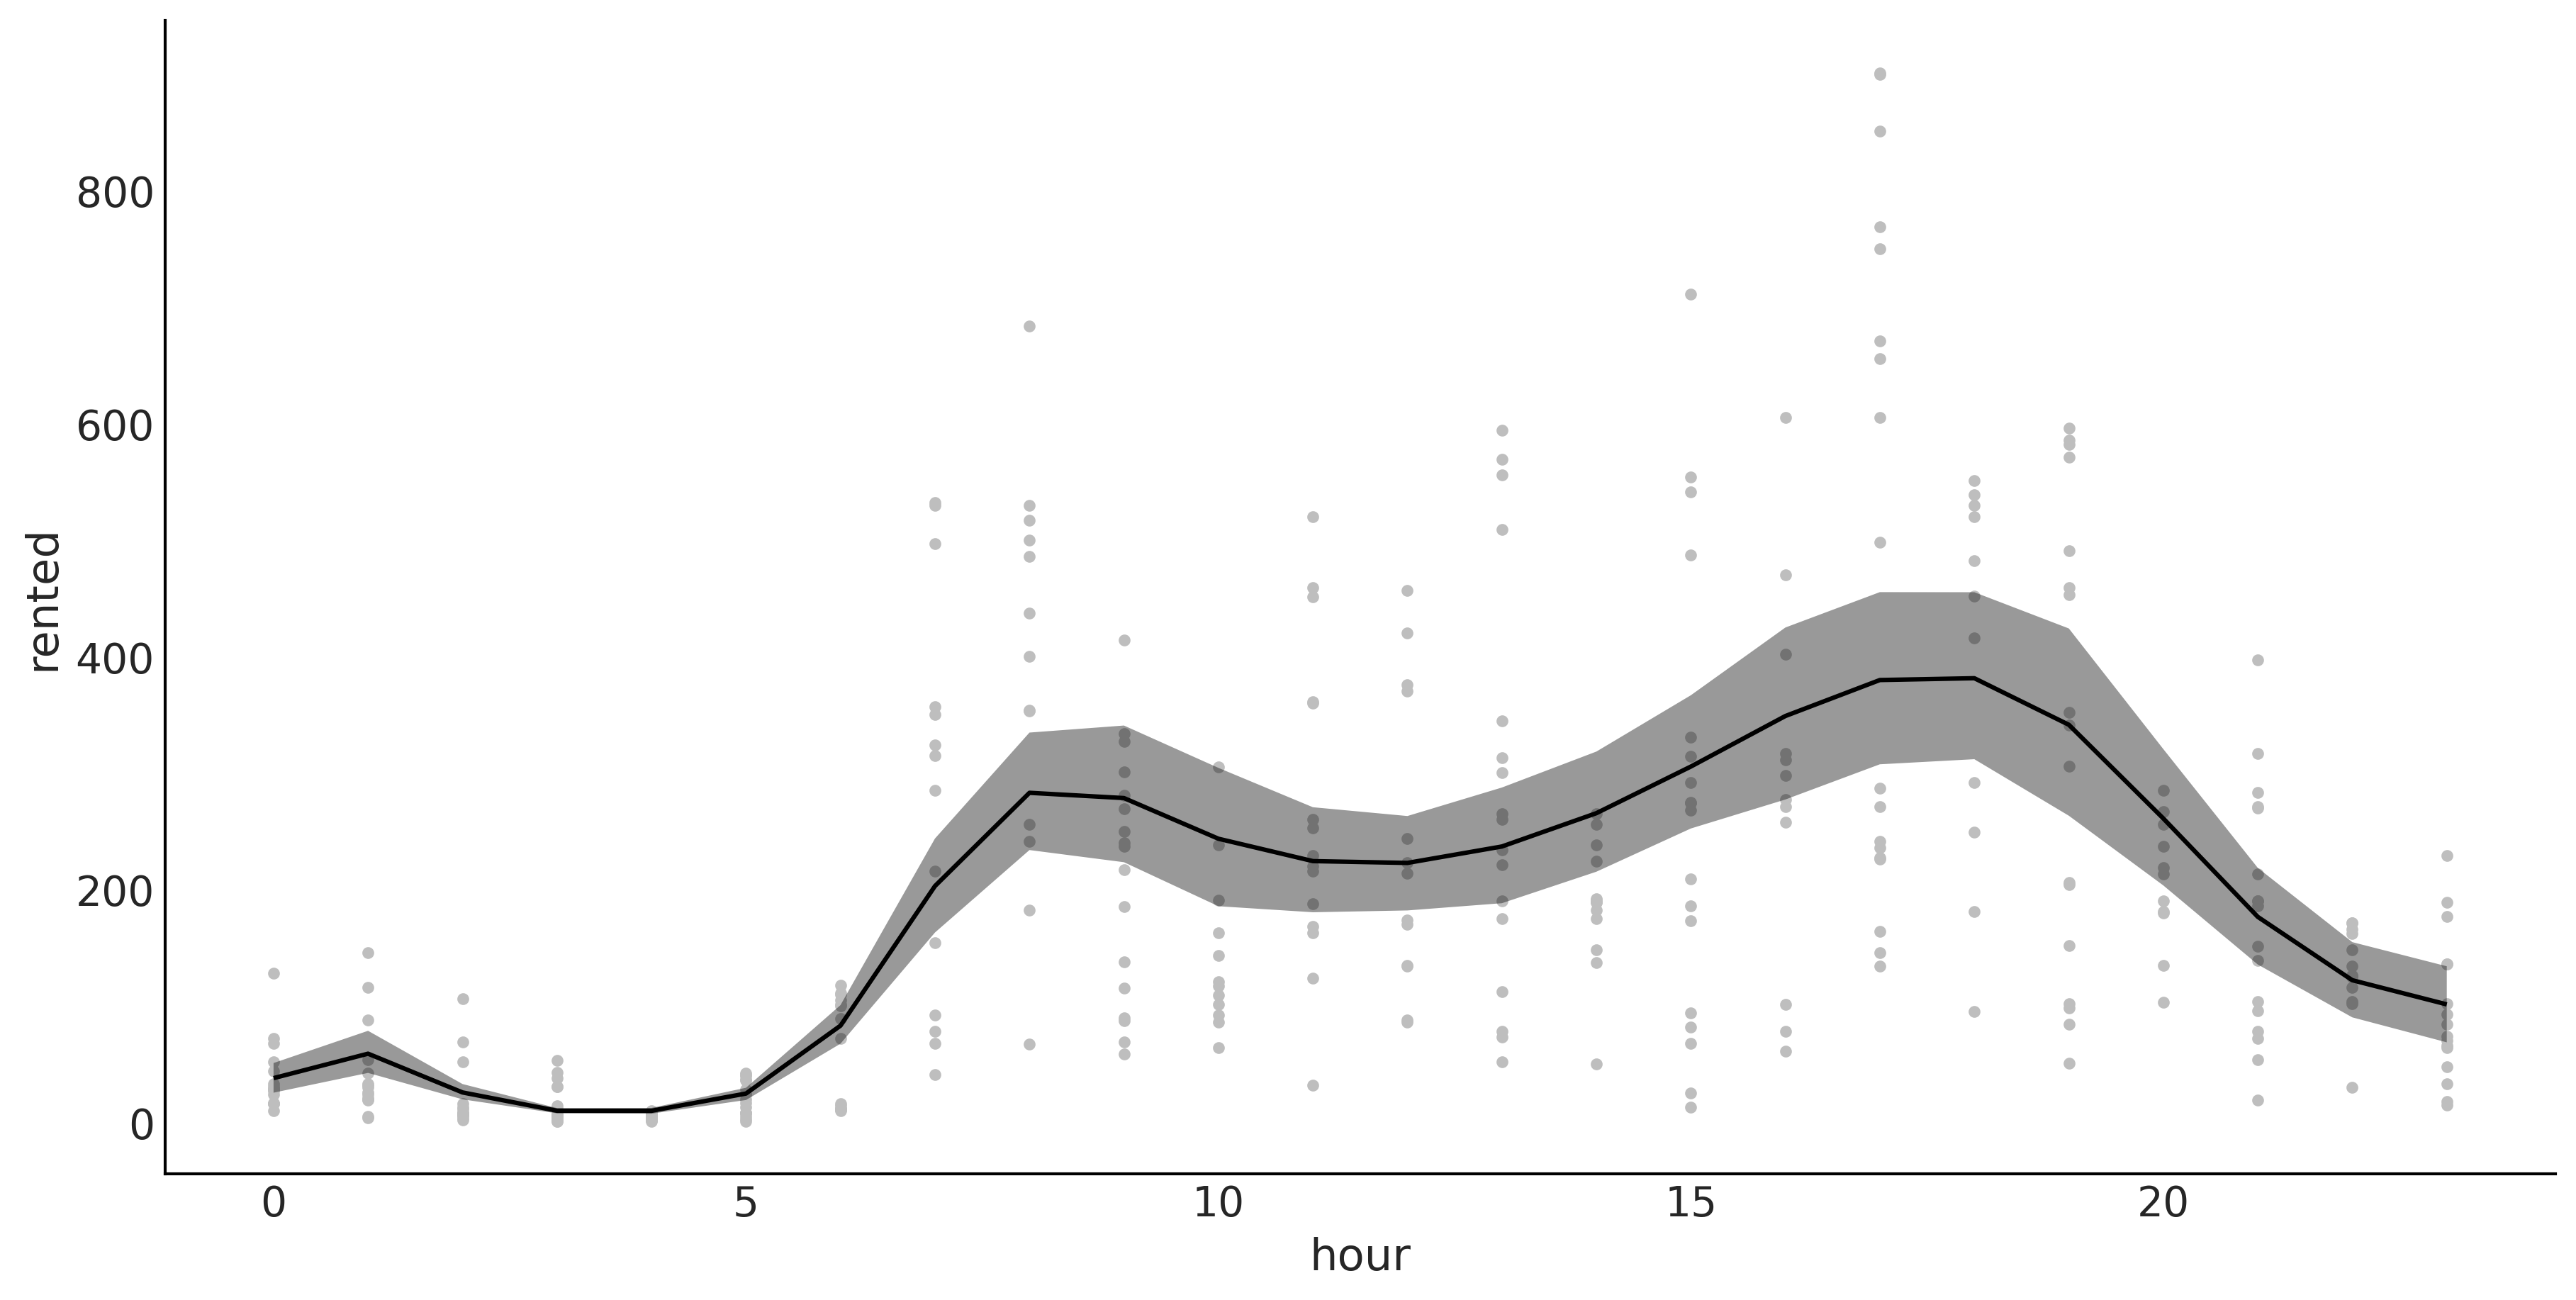

In [21]:
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6)) 
plot_cap(model_spline, idata_spline, "hour", ax=ax)
ax.plot(bikes.hour, bikes.rented, "C2.", zorder=-3)
plt.savefig("../fig/bambi_spline_bikes.png");

## Distributional models

In [22]:
babies = pd.read_csv("data/babies.csv")

In [23]:

formula = bmb.Formula(
    "length ~ np.sqrt(month)",
    "sigma ~ month"
)
model_dis = bmb.Model(formula, babies)
idata_dis = model_dis.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, np.sqrt(month), sigma_Intercept, sigma_month]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [24]:
model_cons = bmb.Model("length ~ np.sqrt(month)", babies)
idata_cons = model_cons.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [length_sigma, Intercept, np.sqrt(month)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


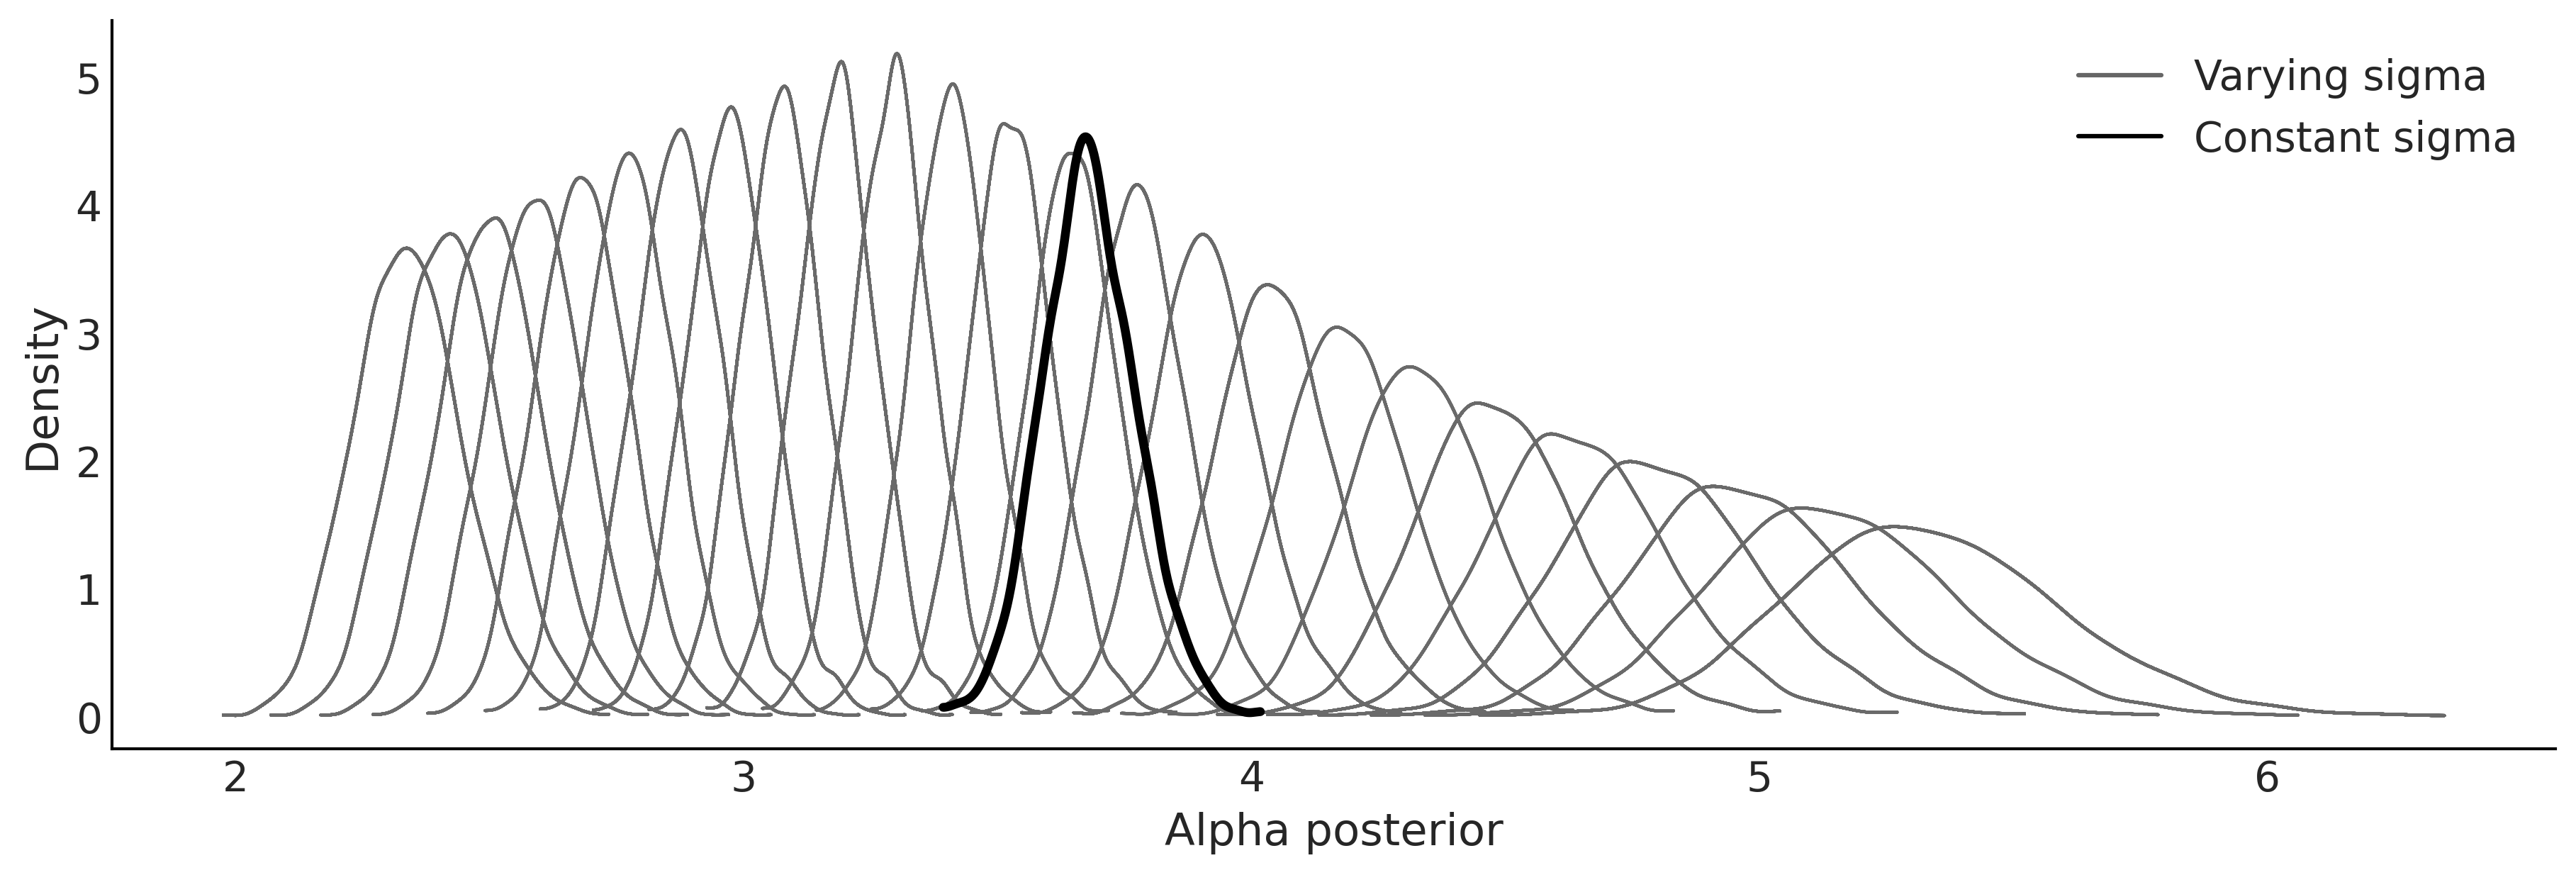

In [25]:
fig, ax = plt.subplots(figsize=(12, 4))
from matplotlib.lines import Line2D

for idx in idata_dis.posterior.coords.get("length_obs"):
    values = idata_dis.posterior["sigma"].sel(length_obs=idx).to_numpy().flatten()
    grid, pdf = az.kde(values)
    ax.plot(grid, pdf, lw=1, color="C1")

values = idata_cons.posterior["length_sigma"].to_numpy().flatten()
grid, pdf = az.kde(values)
ax.plot(grid, pdf, lw=3, color="C0");

# Create legend
handles = [
    Line2D([0], [0], label="Varying sigma", lw=1.5, color="k", alpha=0.6),
    Line2D([0], [0], label="Constant sigma", lw=1.5, color="C0")
]

legend = ax.legend(handles=handles, loc="upper right", fontsize=14)

ax.set(xlabel="Alpha posterior", ylabel="Density")
plt.savefig("../fig/babies_bambi_varying.png")

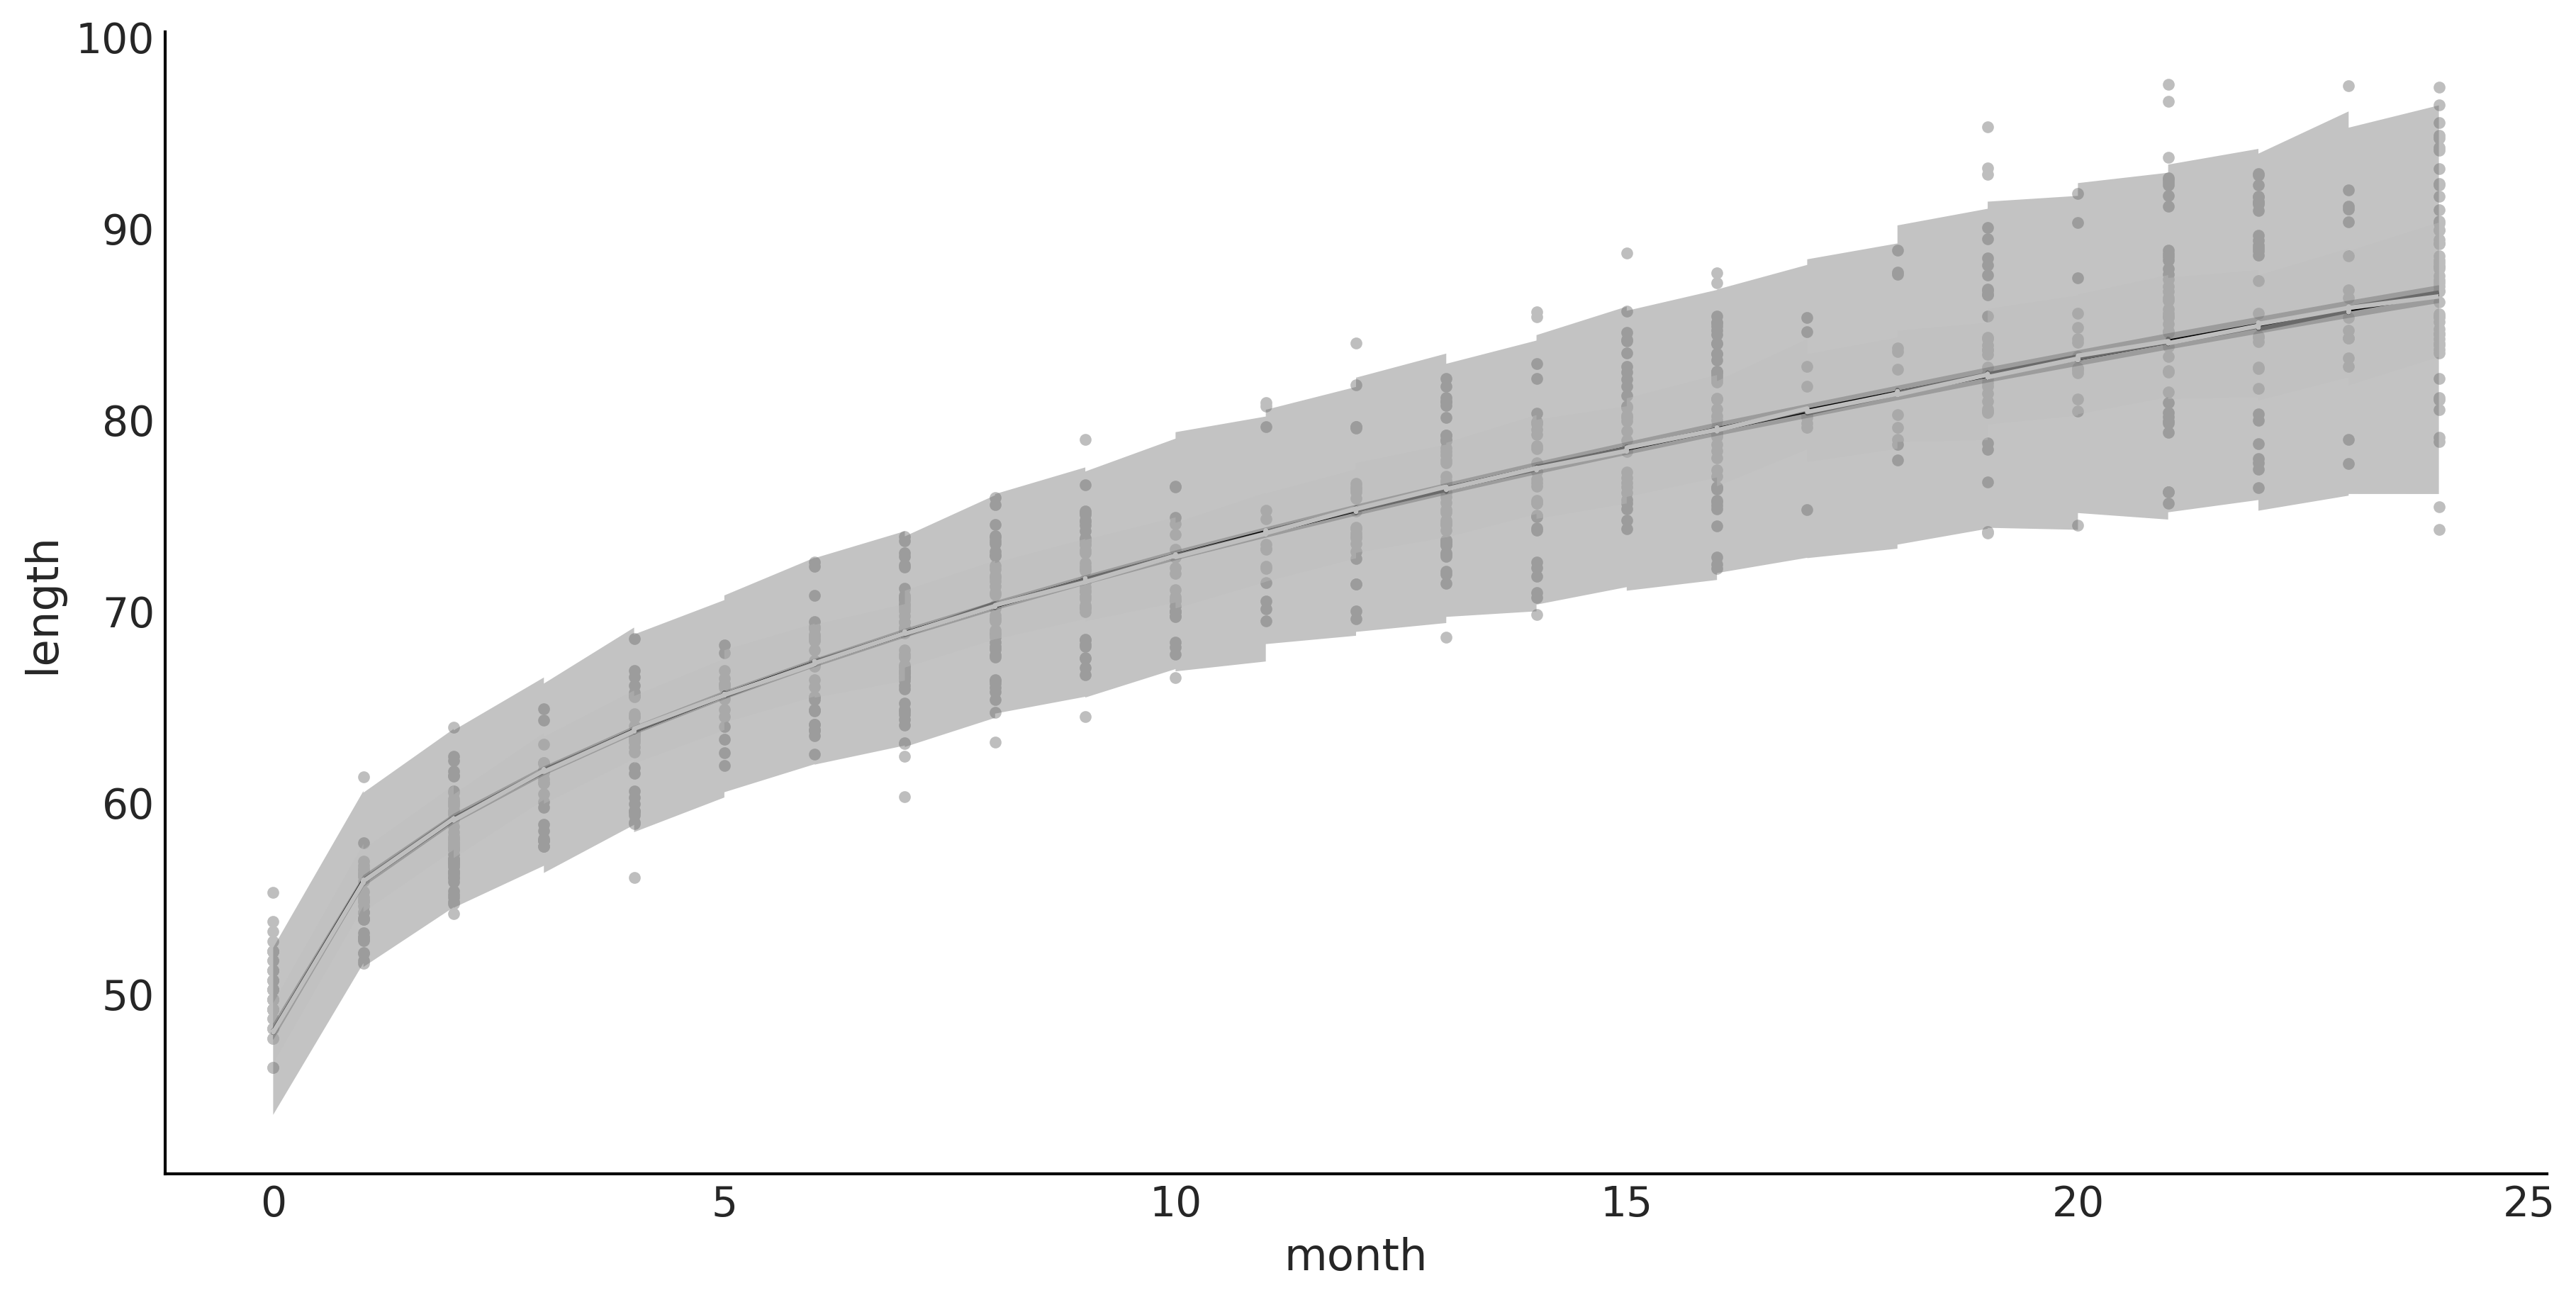

In [43]:
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6)) 
plot_cap(model_dis, idata_dis, "month", ax=ax, fig_kwargs={"color":"k"})
plot_cap(model_dis, idata_dis, "month", pps=True, ax=ax, fig_kwargs={"color":"k"})
plot_cap(model_dis, idata_dis, "month", pps=True, ax=ax, hdi_prob=0.5, fig_kwargs={"color":"C1", "alpha":0.5})

ax.plot(babies.month, babies.length, "C2.", zorder=-3)
plt.savefig("../fig/babies_bambi_fit.png");

In [27]:
model_dis.predict(idata_dis, kind="pps", data=pd.DataFrame({"month":[0.5]}))

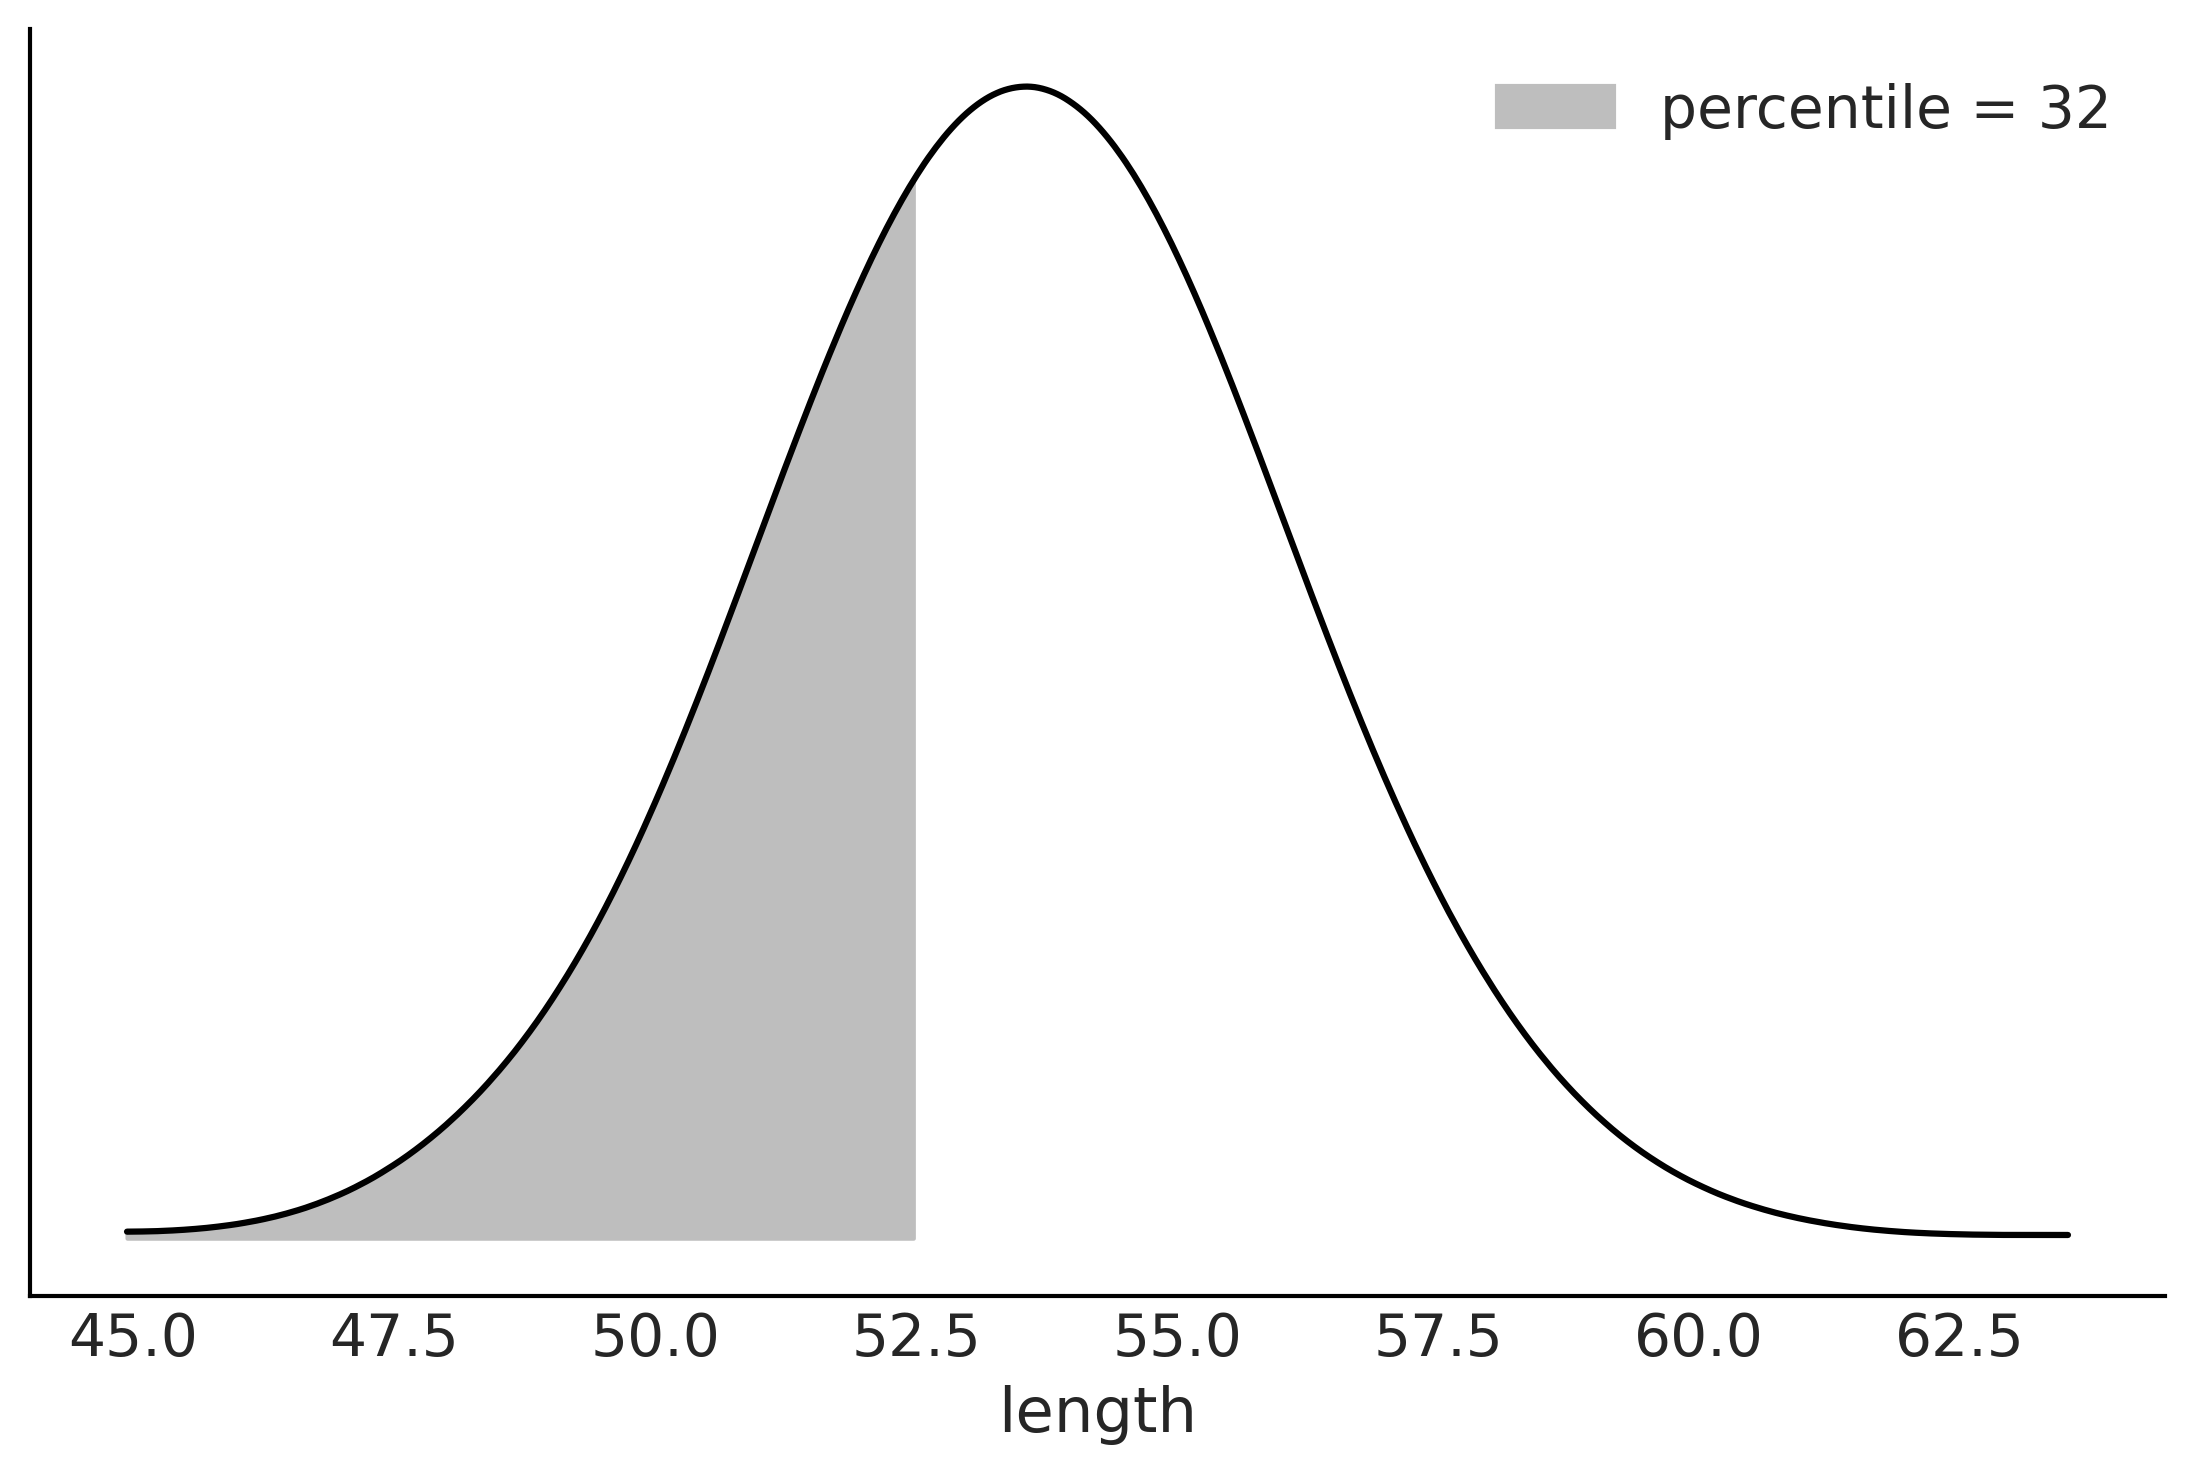

In [28]:
ref = 52.5
y_ppc = idata_dis.posterior_predictive["length"].stack(sample=("chain", "draw"))
grid, pdf = az.stats.density_utils._kde_linear(y_ppc.values)
plt.plot(grid, pdf)
percentile = int((y_ppc <= ref).mean() * 100)
plt.fill_between(
    grid[grid < ref],
    pdf[grid < ref],
    label="percentile = {:2d}".format(percentile),
    color="C2",
)
plt.xlabel("length")
plt.yticks([])
plt.legend()
plt.savefig("../fig/babies_ppc_bambi.png")

In [29]:
## Variable selection with Kulprit